# dmsh to landlab: example 1

In this example we use the *[dmsh](https://github.com/nschloe/dmsh)* package to create a mesh that is then passed in to initialize a *[landlab](https://github.com/landlab/landlab)* grid. In this example we will do the following:

1. Generate a circular mesh with *dmsh*
2. Optionally optimize it with *[optimesh](https://github.com/nschloe/optimesh)*
3. Translate the mesh to *landlab*
4. Assign elevation values to the *landlab* mesh
5. Run the *landlab* flow accumulation routine

### Import libraries

This notebook requires the packages *dmsh*, *landlab*, *numpy* and *matplotlib*. These are all packages that can be **pip**-installed.  

In [1]:
import dmsh
from landlab.plot.imshow import imshow_grid
from landlab.plot.graph import plot_graph
from landlab.grid import VoronoiDelaunayGrid
from landlab.components import FlowAccumulator
from landlab.components import FlowDirectorSteepest
import numpy as np
import matplotlib.pyplot as plt

### Generate mesh (and optimize it)

We start by constructing a circular mesh in *dmsh*. The syntax for this is `geo = dmsh.Circle([Center X-Coord, Center Y-Coord], Diameter)` and then `dmsh.generate(geo, edge_length)`.

After defining the mesh with *dmsh*, we (optionally) optimize it with *optimesh*.

In [2]:
geo = dmsh.Circle([0.0, 0.0], 1.0)
X, cells = dmsh.generate(geo, 0.09)

# try to optimize the mesh using optimesh
try:
    import optimesh
    X, cells = optimesh.cvt.quasi_newton_uniform_full(X, cells, 1.0e-10, 100)
except:
    print('optimesh not installed, mesh is not optimized.')

### Visualize the mesh

We use a built-in *dmsh* function to take a look at what the mesh we've defined actually looks like.

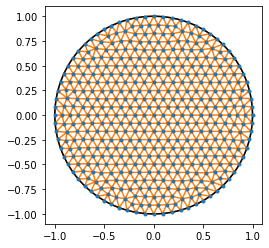

In [3]:
dmsh.helpers.show(X, cells, geo)

### Translate the mesh to landlab

Now we define a *landlab* Voronoi Delaunay unstructured grid using the (x,y) coordinates of the points defined in the *dmsh* grid (stored in the variable `X`).

In [4]:
vmg = VoronoiDelaunayGrid(X[:,0], X[:,1])

### Visualize the landlab mesh
To see how this translation went, we can use one of the built-in *landlab* functions to visualize the *landlab* mesh.

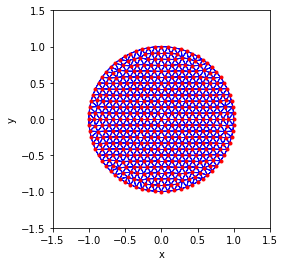

In [5]:
plt.figure(figsize=(4, 4))
plot_graph(vmg, at="link", with_id=False)

### Set landlab grid elevations

Next we will demonstrate now elevation data can be added to this grid.

First we initialize the grid with 0s as elevation values. Then we define all values left of the origin as -1, and those to the right of the origin as 1. 

In [6]:
z_vals = vmg.add_zeros("topographic__elevation", at="node")

In [7]:
for i in range(np.shape(X)[0]):
    if X[i,0] < 0:
        vmg.at_node['topographic__elevation'][i] = -1
    else:
        vmg.at_node['topographic__elevation'][i] = 1

### Visualize the elevations of the mesh

Now that we have assigned elevations to the *landlab* grid, we can visualize the elevations with another one of the built-in *landlab* functions. We expect to see a vertical divide at `x=0` separating the -1 elevations on the left and +1 elevations on the right.

/home/jayh/miniconda3/envs/espin/lib/python3.8/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_bad(color=color_for_closed)


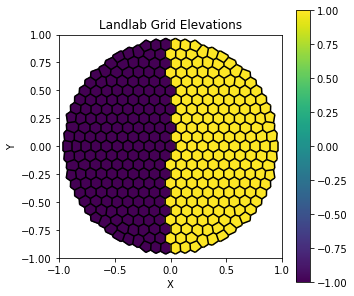

In [8]:
plt.figure(figsize=(5,5))
plt.title('Landlab Grid Elevations')
imshow_grid(vmg, 'topographic__elevation', show_elements=True, cmap='viridis')

### Set grid elevations as function of *x*

That last example of elevation assignment was rather trivial. Let's take a look at how we might assign elevations based on a function `f(x)`. To do this we will first create a function of the form `f(x) = 1 - |x|` and then we will assign elevation values to the grid nodes based on this function. 

In [9]:
def f_elev(x):
    elev = 1 - np.abs(x)
    return elev

In [10]:
for i in range(np.shape(X)[0]):
    vmg.at_node['topographic__elevation'][i] = f_elev(X[i,0])

### Visualize the elevations of the mesh

Again we can use the `imshow_grid()` functionality in *landlab* to visualize this mesh.

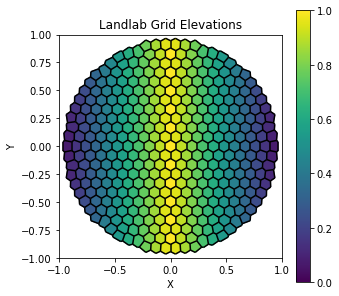

In [11]:
plt.figure(figsize=(5,5))
plt.title('Landlab Grid Elevations')
imshow_grid(vmg, 'topographic__elevation', show_elements=True, cmap='viridis')

### Run landlab flow accumulator and visualize it

Now we'll use the `FlowAccumulator` component of *landlab* to visualize the drainage network on this grid. We expect there to be an accumulation of flow at the left and right boundaries where we have low topography, and no flow accumulation at `x=0` where we have our high elevations.

In [12]:
fa = FlowAccumulator(vmg, 'topographic__elevation',
                     flow_director=FlowDirectorSteepest)

In [13]:
fa.run_one_step()

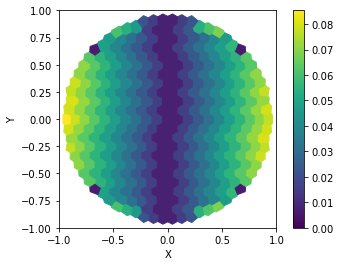

In [14]:
imshow_grid(vmg, 'drainage_area', show_elements=False, cmap='viridis')

### Set grid elevations as function of both *x* and *y*

Here we create a function `f(x,y)` to describe the elevation as a function of both the `x` and `y` position in space. This example is quite similar to the previous one, here we just add a `y` component to the function.

In [15]:
def f_elev(x, y):
    elev = 2 - np.abs(x) - np.abs(y)
    return elev

In [16]:
for i in range(np.shape(X)[0]):
    vmg.at_node['topographic__elevation'][i] = f_elev(X[i,0], X[i,1])

### Visualize the elevations of the mesh

Again we'll use the built-in `imshow_grid()` function to look at the elevations of the mesh.

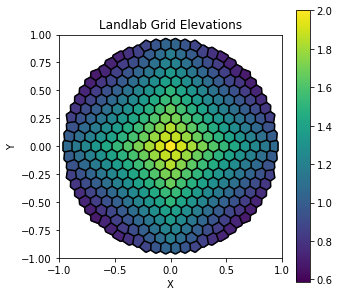

In [17]:
plt.figure(figsize=(5,5))
plt.title('Landlab Grid Elevations')
imshow_grid(vmg, 'topographic__elevation', show_elements=True, cmap='viridis')

### Run landlab flow accumulator and visualize it

Now if we run the `FlowAccumulator` we expect to see an accumulation of flow in the upper left, upper right, lower left, and lower right sections of the grid. 

In [18]:
fa = FlowAccumulator(vmg, 'topographic__elevation',
                     flow_director=FlowDirectorSteepest)

In [19]:
fa.run_one_step()

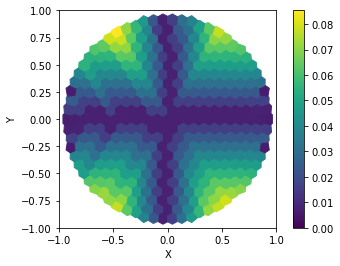

In [20]:
imshow_grid(vmg, 'drainage_area', show_elements=False, cmap='viridis')

### End

Congrats! You've successfully generated a mesh in *dmsh* and imported it into *landlab*. 